In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

### Read in information about the SAM index and EOF (based on u) 

In [2]:
ds_sam = xr.open_dataset("./Eddyfeedback_results/ERA5_1980_2023_SAMindex_u_S20.nc")


In [3]:
ds_sam

<xarray.Dataset>
Dimensions:   (time: 16071, lat: 249)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat       (lat) float64 -89.86 -89.58 -89.3 -89.02 ... -20.67 -20.39 -20.11
Data variables:
    u_sam     (time, lat) float64 ...
    SAMindex  (time) float64 ...
    SAMeof    (lat) float64 ...

### Read in information about m (eddy forcing of the SAM) and [u bar]_s

In [4]:
indir='/work/bk1377/b382037/WP7/Eddyfeedbackstrength/new/' 

ds = xr.open_mfdataset(''+indir+'ERA5_SAMeddyforcingstrength_*_S20_new.nc', concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')


In [5]:
ds

<xarray.Dataset>
Dimensions:      (time: 16071)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
Data variables:
    eddyforcing  (time) float64 dask.array<chunksize=(366,), meta=np.ndarray>
    u1D          (time) float64 dask.array<chunksize=(366,), meta=np.ndarray>

In [6]:
u_eof = ds_sam['SAMeof'].to_numpy()

### Lagged linear regression onto the SAM index...
such that for a lag l,


  m(t+l)~ beta_m(l)PC(t)


u1D(t+l)~ beta_u(l)PC(t)

In [7]:
eddym = ds['eddyforcing'].to_numpy()
u1D   = ds['u1D'].to_numpy()

In [8]:
nt = eddym.shape[0]

In [9]:
samindex=ds_sam['SAMindex'].isel(time=slice(30,nt-31))

In [10]:
delta_t = (ds["time"].diff("time") / np.timedelta64(1, "s")).values
du_dt = (ds["u1D"].isel(time=1) - ds["u1D"].isel(time=0)) / 86400
print(du_dt.values)

-5.2551233345705055e-05


In [11]:
# Calculating the d[u]s/dt: 

u = ds["u1D"].astype("float64")
time_sec = (ds["time"] - ds["time"][0]) / np.timedelta64(1, "s")

du_dt = xr.DataArray(
    np.gradient(u, time_sec),
    dims="time",
    coords={"time": ds["time"]}
)

ds["du_dt"] = du_dt

In [12]:
fricm_res = (ds['du_dt']-ds['eddyforcing']).to_numpy()

In [17]:
lags_size = np.arange(-30,31,1)
print(lags_size.shape)

(61,)


In [19]:
coords_time= {'time':ds.coords['time'].isel(time=slice(30,nt-31)),'lags':np.arange(-30,31,1)}

mlag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)
ulag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)
flag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)
udtlag_window    = xr.DataArray(np.full((61,nt-61),fill_value=np.nan), dims=["lags","time"], coords= coords_time)

for i in range(0+30, nt-31):  # Adjust indices to account for slicing
       # Extract the 60-day window around the current day   
        window_data_m = eddym[i-30:i+31]  
        window_data_u = u1D[i-30:i+31]  
        window_data_f = fricm_res[i-30:i+31]
        window_data_udt = du_dt[i-30:i+31]
        mlag_window.isel(time=i-30).values[:]  = window_data_m
        ulag_window.isel(time=i-30).values[:]  = window_data_u
        flag_window.isel(time=i-30).values[:]  = window_data_f
        udtlag_window.isel(time=i-30).values[:]  = window_data_udt

### For Annual mean

In [20]:
from scipy.stats import linregress

ANNslope_m = np.zeros((61))
ANNslope_u = np.zeros((61))
ANNslope_f = np.zeros((61))
ANNslope_udt = np.zeros((61))

for lag in range (0,61):
    ANNslope_m[lag], _, _, _, _ = linregress(samindex.to_numpy(), mlag_window[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ANNslope_u[lag], _, _, _, _ = linregress(samindex.to_numpy(), ulag_window[lag,:].to_numpy())
    ANNslope_f[lag], _, _, _, _ = linregress(samindex.to_numpy(), flag_window[lag,:].to_numpy())  
    ANNslope_udt[lag], _, _, _, _ = linregress(samindex.to_numpy(), udtlag_window[lag,:].to_numpy())

In [21]:
ANNb = ANNslope_m*86400/ANNslope_u
ANNb_avg= np.mean(ANNb[31+7:31+14])

In [22]:
import matplotlib.pyplot as plt

print(ANNslope_u)

[ 0.97224103  1.1131106   1.21832219  1.28242341  1.34947797  1.4600048
  1.61936956  1.82630715  2.06150388  2.3267795   2.65653625  3.03527975
  3.41581559  3.79411974  4.19379999  4.62972409  5.10664623  5.63344904
  6.18959063  6.76616382  7.38168966  8.02707121  8.70566771  9.46154281
 10.34091615 11.43272055 12.89347655 14.91896638 17.64743907 20.70783663
 22.26936071 20.7024582  17.6732176  14.97242845 12.95933359 11.50260867
 10.40878476  9.51954575  8.7488775   8.05332533  7.39344394  6.76805038
  6.18052992  5.61122517  5.07843791  4.60830079  4.18183962  3.78630554
  3.40501773  3.01499069  2.62383394  2.2884356   2.02174442  1.78989284
  1.59369584  1.44422403  1.33537093  1.2652375   1.20050475  1.09158101
  0.94076776]


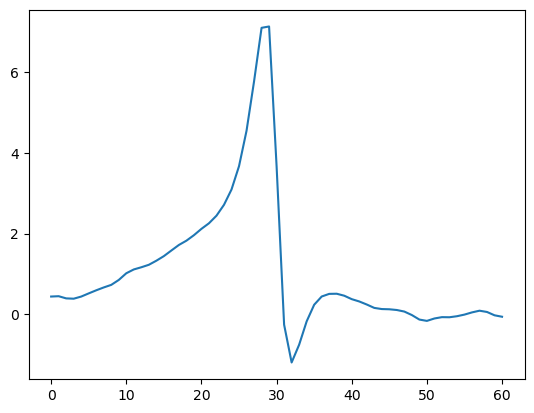

In [23]:
plt.plot(ANNslope_m*86400.)

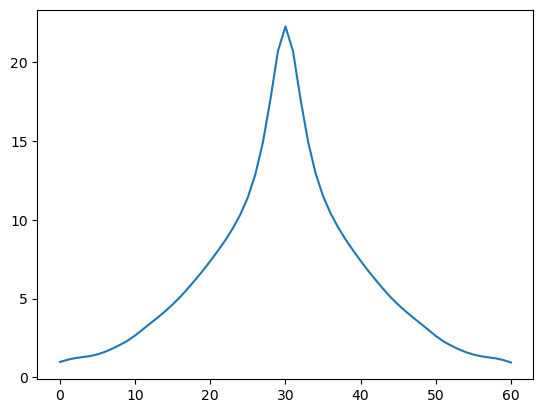

In [24]:
plt.plot(ANNslope_u)

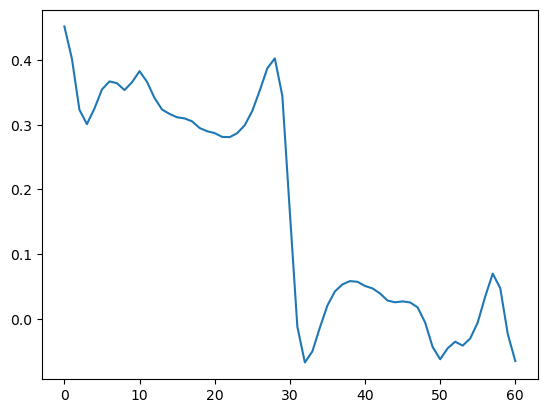

In [25]:
plt.plot(ANNb)

### For NDJ

In [26]:
NDJ_mlag = mlag_window.sel(time=mlag_window.time.dt.month.isin([11, 12, 1]))
NDJ_ulag = ulag_window.sel(time=ulag_window.time.dt.month.isin([11, 12, 1]))
NDJ_flag = flag_window.sel(time=flag_window.time.dt.month.isin([11, 12, 1]))
NDJ_udtlag = flag_window.sel(time=udtlag_window.time.dt.month.isin([11, 12, 1]))

In [27]:
NDJ_SAMindex = samindex.sel(time=samindex.time.dt.month.isin([11, 12, 1]))

In [28]:
NDJslope_m = np.zeros((61))
NDJslope_u = np.zeros((61))
NDJslope_f = np.zeros((61))
NDJslope_udt = np.zeros((61))

for lag in range (0,61):
    NDJslope_m[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_mlag[lag,:].to_numpy())  #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    NDJslope_u[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_ulag[lag,:].to_numpy())
    NDJslope_f[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_flag[lag,:].to_numpy())
    NDJslope_udt[lag], _, _, _, _ = linregress(NDJ_SAMindex.to_numpy(), NDJ_udtlag[lag,:].to_numpy())

In [29]:
NDJb = NDJslope_m*86400/NDJslope_u
NDJb_avg= np.mean(NDJb[31+7:31+15])

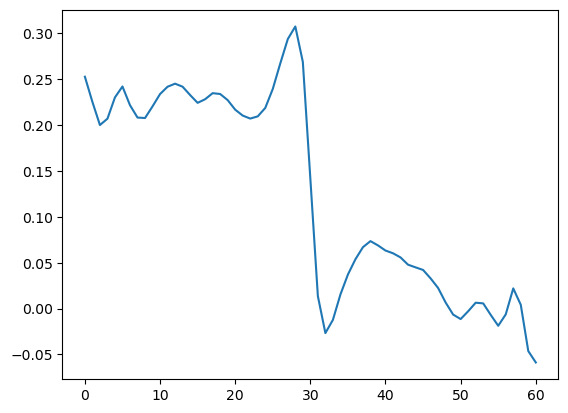

In [30]:
plt.plot(NDJb)

In [31]:
np.savetxt('ERA5_1980_2023_ANNslope_fres.out', ANNslope_f*86400, delimiter=',')
np.savetxt('ERA5_1980_2023_NDJslope_fres.out', NDJslope_f*86400, delimiter=',')

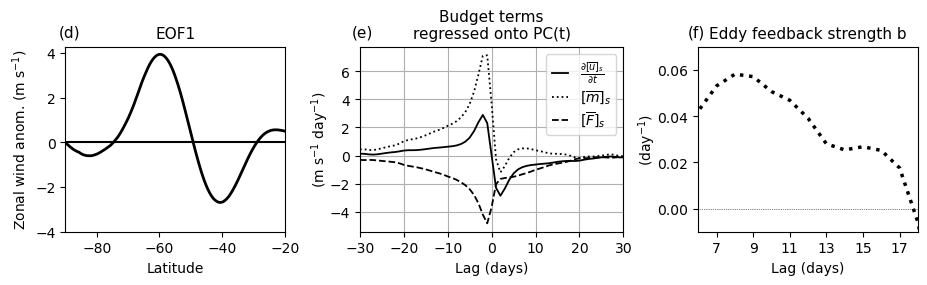

In [70]:

fig = plt.figure(figsize=(11,2.4))
gs = fig.add_gridspec(1, 3,  width_ratios=(1, 1.2, 1))
#----------------------------------------
ax = fig.add_subplot(gs[0])

plt.plot(ds_sam.coords['lat'].values, u_eof[:],color='k', linewidth=2)
ax.axhline(0, color='k')
ax.set_xlim(-90, -20)
ax.set_yticks(np.arange(-4,6,2))
#ax.set_yticklabels(np.arange(-40,12,10))
ax.set_xlabel('Latitude')
ax.set_ylabel('Zonal wind anom. ' r'$(\mathrm{m}$'' 'r'$\mathrm{s}^{-1})$')
ax.set_title('EOF1', fontsize=11)
plt.text(-0.03, 1.12, '(d)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)
#----------------------------------------
ax = fig.add_subplot(gs[1])
plt.plot(lags_size, ANNslope_udt*86400, color='k', linewidth=1.3,label=r'$\frac{\partial[\overline{u}]_s}{\partial t}$')
plt.plot(lags_size, ANNslope_m*86400, color='k', linewidth=1.3, linestyle='dotted',label=r'$[\overline{m}]_s$')
plt.plot(lags_size, ANNslope_f*86400, color='k', linewidth=1.3, linestyle='dashed',label=r'$[\overline{F}]_s$')

ax = plt.gca()
ax.set_xlim(-30,30)
ax.set_yticks(np.arange(-4,8,2))

ax.set_ylabel(r'$(\mathrm{m}$'' 'r'$\mathrm{s}^{-1}$'' 'r'$\mathrm{day}^{-1})$',y=0.8, x=0)
#adjust position of x-axis label
ax.yaxis.set_label_coords(-0.11, .5)
ax.set_title(r'$\beta_m$'', 'r'$\beta_u$', fontsize=11)
ax.set_title('Budget terms\nregressed onto PC(t)', fontsize=11)
ax.set_xlabel('Lag (days)')

ax.grid()
plt.legend(handlelength=1.2, labelspacing =0.3)
plt.text(-0.03, 1.12, '(e)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)


#----------------------------------------
ax = fig.add_subplot(gs[2])

plt.plot(lags_size, ANNb, color='k', linestyle='dotted',linewidth=2.5, label='eddy feedback($b$)')

ax.axhline(y=0, xmin=0, xmax=30, color='k', linestyle='dotted',linewidth=0.5) 
ax = plt.gca()
ax.set_xlim(6,18)
ax.set_ylim(-0.01,0.07)
ax.set_xticks(np.arange(7,18,2))
plt.text(-0.05, 1.12, '(f)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)
ax.set_title('Eddy feedback strength b', fontsize=11)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('('r'$\mathrm{day}^{-1})$', labelpad=0)

plt.subplots_adjust(wspace=0.32) #0.26
plt.savefig('Fig1_part2_ERA5_Eddyfeedback_example_1980-2023_addfres', bbox_inches='tight', dpi=200)



plt.show()